# Neural Networks


# Part I of the experiment

#### Describe both the model you are starting (control) with and the modification you are evaluating (experimental). What effect do you think your modification will have on training? On overall model performance? Next give a short description of what data you will use in your experiments (e.g. how many images, their format, and how many classes).

In this experiment we are starting with a nonlinear neural network with one hidden layer that has 400 neurons. We are testing the effect of increasing the number of neurons in the hidden layer by 0.5 using the same network architecture, input features and output features. The only parameter we are chaning is the number of neurons in the hidden layer. We are increasing the number of neurons from 400 to 600 to examine how this change will affect validation and training accuracy. 

The neural network we are strating with has 12,288 input features, 200 output features and 400 neurons in the hidden layer. Relative to the number of input features, it seems like we have a few number of neurons in the hidden layer. Using too few neurons in the hidden layer will result in underfitting. We are making the assumptions that 400 neurons in the hidden layer is too few. Therefore, by increasing the number of neurons in the hidden layer we expect the validation accuracy to increase and the training accuracy to decrease. Through the experiment we will test if our assumption is true or not. 

Our data are a set of images that comes from the Tiny Imagenet Visual Recognition Challenge. There are 200 classes in total. Our training set contains 500 images for each of the 200 different classes. The validation set contains 50 images for each of the 200 classes. Our aim is to predict the class label of each image. 

## Helper and Data Loading Functions

In [1]:
%matplotlib inline
%run Helpers.py

In [2]:
def load_train_dataset():
    data_path = './tiny-imagenet-200/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

In [3]:
def load_valid_dataset(class_to_idx):
    data_path = './tiny-imagenet-200/val/images'
    label_file = open('./tiny-imagenet-200/val/val_annotations.txt', 'r')
    label_df = pd.read_csv(label_file, delim_whitespace=True, header=None)
    label_df[1] = label_df[1].apply(lambda x : class_to_idx[x])
    valid_data = []
    for row in label_df.iterrows():
        image = Image.open(f'{data_path}/{row[1][0]}')
        image = torchvision.transforms.functional.to_tensor(image)
        label = row[1][1]
        valid_data.append((image, label))
    return valid_data

In [4]:
def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

    valid_data_np = []
    valid_labels = []
    for data, label in valid_dataset:
        if data.shape[0] < 3:
            data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
        valid_data_np.append(data.detach().numpy().flatten())
        valid_labels.append(int(label))
    valid_data_np = np.vstack(valid_data_np)
    valid_labels = np.array(valid_labels)
    return train_data_np, train_labels, valid_data_np, valid_labels

In [5]:
train_dataset, class_to_idx = load_train_dataset()
valid_dataset = load_valid_dataset(class_to_idx)

## Nonlinear Neural Network With One Hidden Layer and 400 Neurons in the Hidden Layer

In [6]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [7]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        super().__init__() 
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

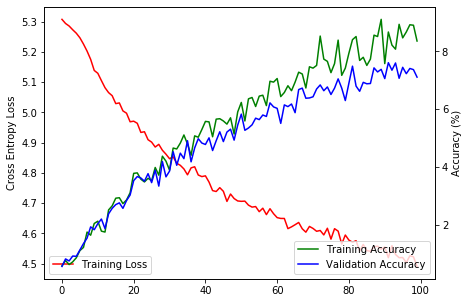

In [8]:
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

# Part 2 of the experiment

## Nonlinear Neural Network With One Hidden Layer and 600 Neurons in the Hidden Layer

In [13]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [21]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        super().__init__()
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=600)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=600, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        #X = self.dense3(X)
        #X = self.activation3(X)

        return X

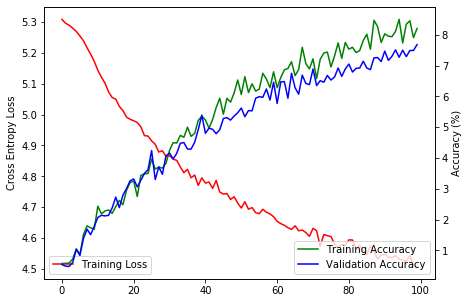

In [22]:
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Summary of Results

#### Give a summary of results, clearly indicating the experimental condition to which they belong (i.e. control or experimental). Comment on your results. Did your modification improve your image classifier? What evidence do you have to support this? 

After running the experiment with the 600 neurons in the hidden layer of the neural network we see an increase in the validation accuracy and a slight drop in training accuracy. Both the training accuracy and the validation accuracy belong to the experiment group since they are exposed to the changes in the number of neurons in the hidden layer that we are testing. 

Yes, the modification did improve the classification slightly. The evidence for that is the increase in validation accuracy we see from the graph above.

#### Based on your observations or any other sources, what additional changes do you think could further improve your model? Do you think the training data you used contained sufficient training examples for your model to generalize well? Justify your claim.

I think adding additional neurons in the hidden layer of the neural network may still improve the results slightly. Finding the right number of neurons would maximize the accuracy of classification. If we use too many neurons this can cause overfitting. On the other hand, if we use too little neurons in the hidden layer then we will have an underfitting problem. The right balance of neurons is how we can maximize the accuracy of our classification. We have 12,288 input features and 200 output features. When we increased the neurons in the hidden layer from 400 to 600 our classification accuracy improved. It seems like there is room to increase the number of neurons in the hidden layer to improve the results without causing overfitting. Additionally, changing the network architecture in other ways such as adding additional hidden layers can result in improving the results. It may also cause overfitting. The results of adding an additional hidden layer would be interesting to investigate. I tried running this experiment on my laptop but the hardware capabilities of the laptop didn't help me finish this experiment in a timely manner.

If the neural network had too much information processing capacity than the amount of information contained in the training set to train all of the neurons in the hidden layer, then we would have an overfitting problem. On the other hand, if the neural network had too little information processing capacity than the amount of information contained in the training set to train all the neurons in the hidden layer, then we will have an underfitting problem. From the graph, we can see that the training accuracy is higher than the validation accuracy. At the same time there is not a big difference between training accuracy and validation accuracy. This suggests we are not facing an overfitting or an underfitting problem, so we should have sufficient training examples. However, its worth mentioning that we only trained our network for 100 iterations and the results might be different if we train the network for more iterations.